In [1]:
import math as m
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

from pymatgen.util import coord
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.core.sites import Site
from ase.visualize.plot import plot_atoms
from copy import copy, deepcopy

In [2]:
#Formulas for calculating formation energy based on the distance between vacancies 

def vacanciesS_S(x): #general S-S function ignoring the difference of layers (not used)
    return -1/(15 + 2 * x)

def vacanciesS_SoneLayer(x):
    return m.cos(1 - x) /(15 + 2 * x)

def vacanciesS_SdifLayer(x):
    return m.cos(5 - x) / ((2**x) + 1 + x)

def vacanciesS_Mo(x):
    return (m.cos(0.5) * m.cos(8 - 2 * x) - 1)* x**2 * m.exp(-x)

energyForS = 2.693
energyForMo = 7.097

In [3]:
# Fucntion that prints the structure based on it's initial_structure
def printStructure(d):
    s0 = d.initial_structure
    d0 = list(d.defect_representation)
    ase_atoms = AseAtomsAdaptor.get_atoms(s0)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)
    ax.set_title(f'{d0}')

In [4]:
#Calculates distance between two defects
def distanceCalc(pos, defect, emptyStructure):
    x = (emptyStructure.initial_structure[pos].frac_coords[0] - emptyStructure.initial_structure[defect].frac_coords[0]) ** 2
    y = (emptyStructure.initial_structure[pos].frac_coords[1] - emptyStructure.initial_structure[defect].frac_coords[1]) ** 2
    z = (emptyStructure.initial_structure[pos].frac_coords[2] - emptyStructure.initial_structure[defect].frac_coords[2]) ** 2
    distance = m.sqrt(x + y + z)
    return distance

#Identifies the best position for the new defect using greedy algorithm
#Given the type of defect goes through all possible positions and calculates the formation energy
#adds the position with the best (closest) formation energy to defects 
def addDefect(energy, current_e, positions, defType, emptySructure):
    chosen = -1
    chosen_e = 0
    if not len(positions):
        if defType == "l1S":
            chosen = np.random.randint(64, 127)
            chosen_e = energyForS
        elif defType == "l2S":
            chosen = np.random.randint(128, 191)
            chosen_e = energyForS
        elif defType == "Mo":
            chosen = np.random.randint(0, 63)
            chosen_e = energyForMo
        positions.append(chosen)
        return 0

    if defType == "l1S":
        current_e += energyForS
        for i in range(64, 128):
            if i not in positions:
                new_e = 0
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    if defect > 127:
                        new_e += vacanciesS_SdifLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        new_e += vacanciesS_SoneLayer(distance)
                if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                    chosen = i
                    chosen_e = new_e

    elif defType == "l2S":
        current_e += energyForS
        for i in range(128, 192):
            if i not in positions:
                new_e = 0
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    if defect > 127:
                        new_e += vacanciesS_SoneLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        new_e += vacanciesS_SdifLayer(distance)
                if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                    chosen = i
                    chosen_e = new_e

    elif defType == "Mo":
        current_e += energyForMo
        for i in range(0, 64):
            if i not in positions:
                new_e = 0
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    if defect > 63:
                        new_e += vacanciesS_Mo(distance)
                if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                    chosen = i
                    chosen_e = new_e
    positions.append(chosen)
    return current_e + chosen_e

In [5]:
#WIP version of 'addDefect' with 50% chance to take the second best result of the greedy algorithm
def addDefectWIP(energy, current_e, positions, defType, emptySructure):
    chosen = -1
    chosen_e = 0
    if not len(positions):
        if defType == "l1S":
            chosen = np.random.randint(64, 128)
            chosen_e = energyForS
        elif defType == "l2S":
            chosen = np.random.randint(128, 192)
            chosen_e = energyForS
        elif defType == "Mo":
            chosen = np.random.randint(0, 64)
            chosen_e = energyForMo
        positions.append(chosen)
        return 0
    
    if defType == "l1S":
        current_e += energyForS
        for i in range(64, 128):
            if i not in positions:
                new_e = 0
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    if defect > 127:
                        new_e += vacanciesS_SdifLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        new_e += vacanciesS_SoneLayer(distance)
                if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                    chosen = i
                    chosen_e = new_e
        close_choice = [chosen-8, chosen-1, chosen, chosen+1, chosen+8]
        chosen = random.choice(list(filter(lambda x: 128 > x >= 64, close_choice)))
        chosen_e = 0
        for defect in positions:
                    distance = distanceCalc(chosen, defect, emptySructure)
                    if defect > 127:
                        chosen_e  += vacanciesS_SdifLayer(distance)
                    elif defect < 64:
                        chosen_e  += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        chosen_e  += vacanciesS_SoneLayer(distance)
                        
                        
    elif defType == "l2S":
        current_e += energyForS
        for i in range(128, 192):
            if i not in positions:
                new_e = 0
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    if defect > 127:
                        new_e += vacanciesS_SoneLayer(distance)
                    elif defect < 64:
                        new_e += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        new_e += vacanciesS_SdifLayer(distance)
                if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                    chosen = i
                    chosen_e = new_e
        close_choice = [chosen-8, chosen-1, chosen, chosen+1, chosen+8]
        chosen = random.choice(list(filter(lambda x: 192 > x >= 128, close_choice)))
        chosen_e = 0
        for defect in positions:
                    distance = distanceCalc(chosen, defect, emptySructure)
                    if defect > 127:
                        chosen_e += vacanciesS_SoneLayer(distance)
                    elif defect < 64:
                        chosen_e += vacanciesS_Mo(distance)
                    elif 64 <= defect <= 127:
                        chosen_e += vacanciesS_SdifLayer(distance)
    elif defType == "Mo":
        current_e += energyForMo
        for i in range(0, 64):
            if i not in positions:
                new_e = 0
                for defect in positions:
                    distance = distanceCalc(i, defect, emptySructure)
                    if defect > 63:
                        new_e += vacanciesS_Mo(distance)
                if (new_e + current_e - energy) ** 2 < (chosen_e + current_e - energy) ** 2 or chosen == -1:
                    chosen = i
                    chosen_e = new_e
        close_choice = [chosen-8, chosen-1, chosen, chosen+1, chosen+8]
        chosen = random.choice(list(filter(lambda x: 64 > x >= 0, close_choice)))
        chosen_e = 0 
        for defect in positions:
                    distance = distanceCalc(chosen, defect, emptySructure)
                    if defect > 63:
                        chosen_e += vacanciesS_Mo(distance)
    positions.append(chosen)
    return current_e + chosen_e

In [6]:
#Stearter func for 2 defects
#Using brute force combination produces every combination of given elements and add them using addDefect function
#basicly [l1S, l2S, Mo] x [l1S, l2S, Mo]
#Returns optimal positions for the defects as well as formation energies of resulting structures
def twoDefects(energy, emptySructure, elements):
    defects = []
    for x in elements:
        for y in elements:
            if [x, y].count('Mo') <= 1:
                positions = []
                current_e = 0
                current_e = addDefectWIP(energy, current_e, positions, x, emptySructure)
                current_e = addDefect(energy, current_e, positions, y, emptySructure)
                defects.append([current_e, positions])
    return defects

#Stearter func for 3 defects
#Same as 'twoDefects'
def threeDefects(energy, emptySructure, elements):
    defects = []
    for x in elements:
        for y in elements:
            for z in elements:
                if [x, y, z].count('Mo') <= 1:
                    positions = []
                    current_e = 0
                    current_e = addDefectWIP(energy, current_e, positions, x, emptySructure)
                    current_e = addDefectWIP(energy, current_e, positions, y, emptySructure)
                    current_e = addDefect(energy, current_e, positions, z, emptySructure)
                    defects.append([current_e, positions])
    return defects

#Starter algorithm for any number of defects
#Randomly constructs a combination of elements instead of brute force
#The remaining prosses is the same 
def anyNumDefects(energy, emptySructure, elements, number_of_defects):
    defects = []
    for i in range(3 ** number_of_defects):
        combination = []
        for i in range(number_of_defects):
            defType = random.choice(elements)
            combination.append(defType)
        if combination.count('Mo') <= 1:
            positions = []
            current_e = 0
            for i in range(number_of_defects - 1):
                current_e = addDefectWIP(energy, current_e, positions, combination[i], emptySructure)
            current_e = addDefect(energy, current_e, positions, combination[-1], emptySructure)
            defects.append([current_e, positions])
    return defects     

In [7]:
#application of defects to the MoS2 structure 
#tekes positions of the defects and adds them to initial_structure
def applyDefects(defects):
    emptySructure = pd.read_pickle('emptydata.pkl')
    emptySructure = emptySructure.iloc[0]
    emptySructure.defect_representation.clear()
    for i in range(len(defects)):
        if defects[i] < 64:
            emptySructure.initial_structure.replace(defects[i], Element('W'))
        else:
            emptySructure.initial_structure.replace(defects[i], Element('Li'))
        emptySructure.defect_representation.append(emptySructure.initial_structure[defects[i]].species,
                                                   emptySructure.initial_structure[defects[i]].frac_coords)
    return emptySructure

Expected formation energy: 12
Number of defects: 3
How many examples: 4
Maximum divergence from required energy: 8
What vacancies should be considered (l1S, l2S, Mo): l1S l2S Mo
Energy: 9.805094749444745 Defects: [164, 43, 172]


C:\Users\lebed\AppData\Local\Temp\ipykernel_28108\1077633895.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


Energy: 9.800374768942577 Defects: [115, 70, 50]


C:\Users\lebed\AppData\Local\Temp\ipykernel_28108\1077633895.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


Energy: 9.799331241515013 Defects: [181, 135, 7]


C:\Users\lebed\AppData\Local\Temp\ipykernel_28108\1077633895.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


Energy: 9.796300146454127 Defects: [108, 35, 92]


C:\Users\lebed\AppData\Local\Temp\ipykernel_28108\1077633895.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append(newData)


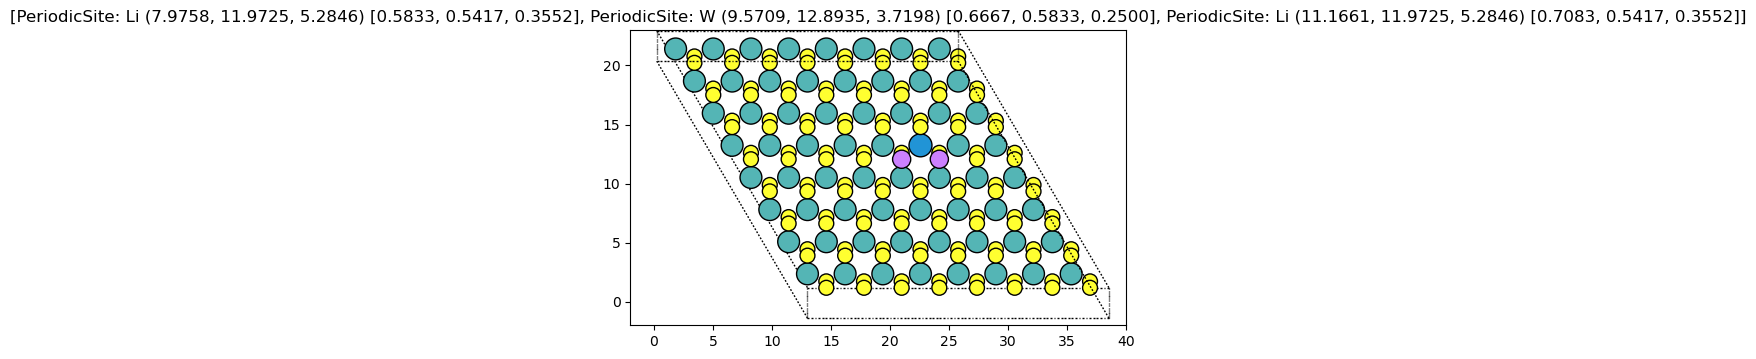

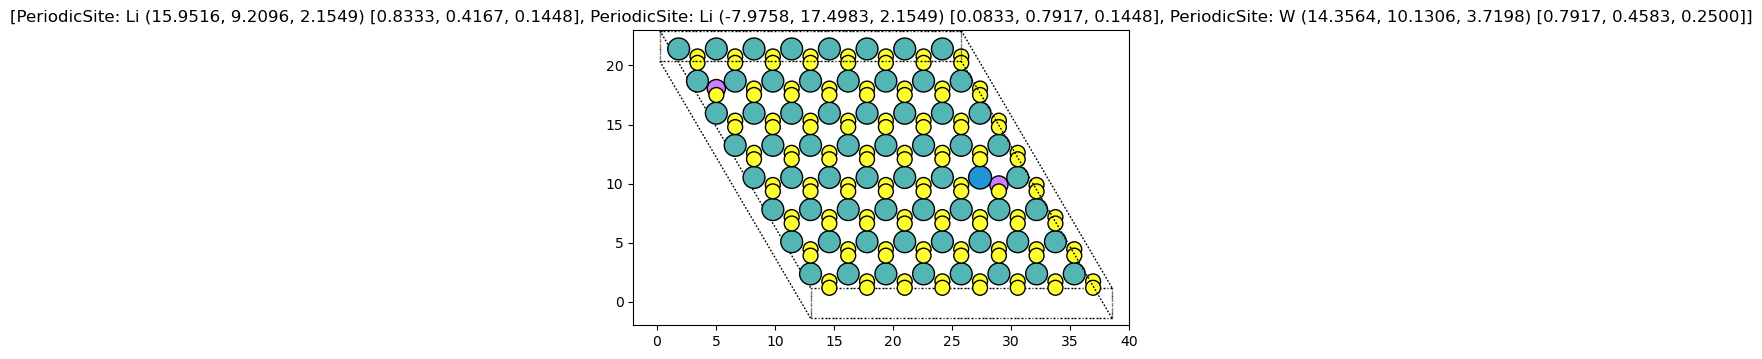

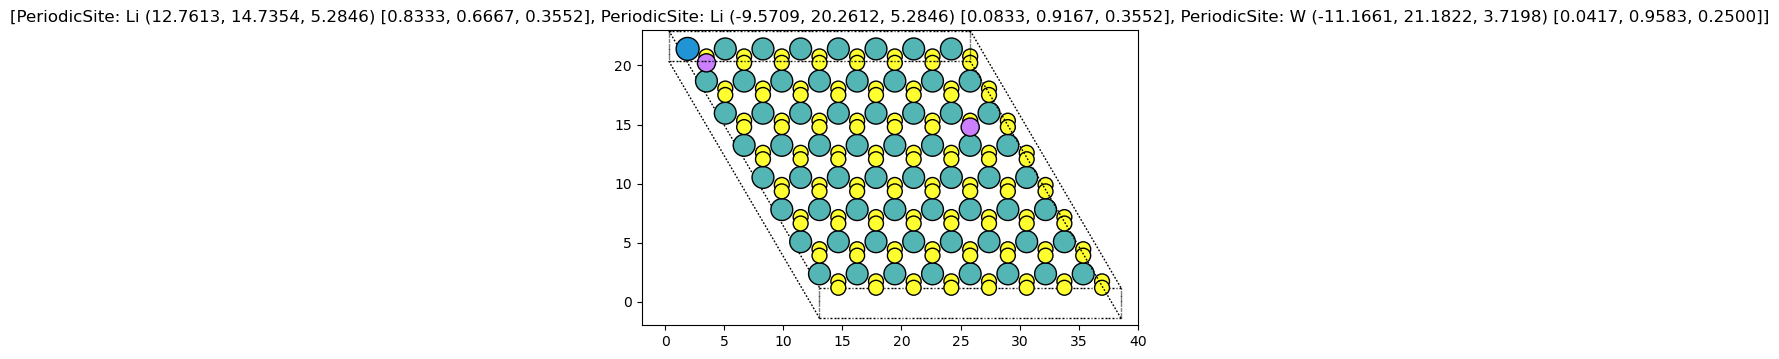

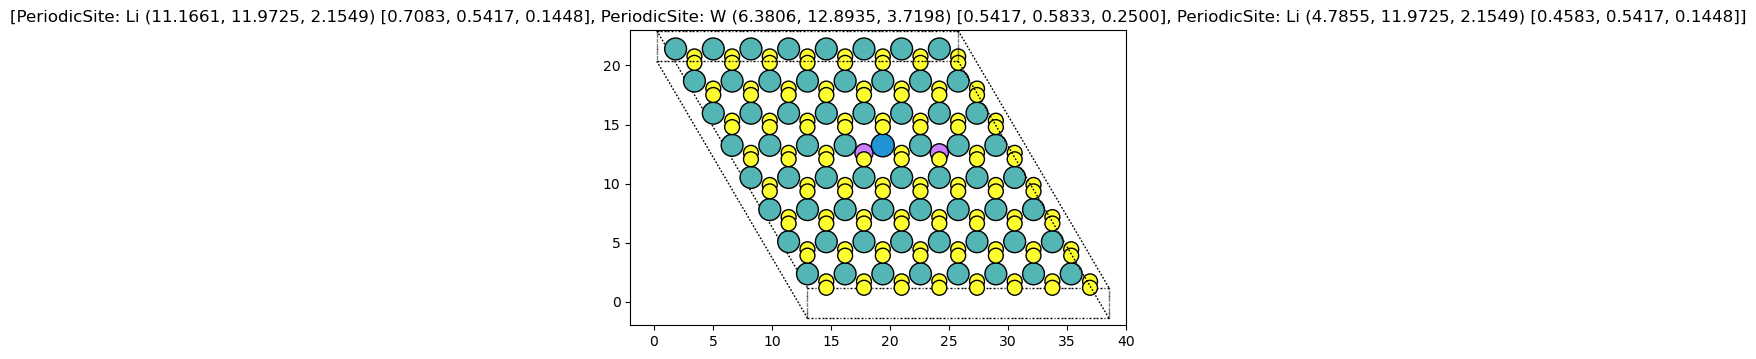

In [14]:
dataBegin = pd.read_pickle('emptydata.pkl')
dataBegin = dataBegin.iloc[0]
dataBegin.defect_representation.clear()

energy = float(input("Expected formation energy: ")) #What formation energy we are trying to achive 
number_of_defects = int(input("Number of defects: ")) #How many defects should be used
number_of_examples = int(input("How many examples: ")) #How many examples to display
epsilon = float(input("Maximum divergence from required energy: ")) #By how much can the resulting energy vary form expected val 
elements = list(input("What vacancies should be considered (l1S, l2S, Mo): ").split()) #Vacancies of what elements can be used


#if (energy > number_of_defects * energyForMo + epsilon) or (energy < number_of_defects * energyForS + epsilon):
#    print("Impossible combination of paraments\nNo such structure can be constructed")
#else:
#Choose a starter function nased on the number of defects
#Will be removed in favour of 'anyNumDefects'
if number_of_defects == 2:
    defects = twoDefects(energy, dataBegin, elements)
elif number_of_defects == 3:
    defects = threeDefects(energy, dataBegin, elements)
elif number_of_defects > 3:
    defects = anyNumDefects(energy, dataBegin, elements, number_of_defects)

#Sort the structures with closes formation energy
sortedDefects = sorted(defects, key=lambda x: (x[0] - energy)**2)

#This segment filters structures based on the epsilon variation
#Displays and saves successfully generated structures 
allData = pd.DataFrame()
for i in range(min(number_of_examples, len(sortedDefects))):
    if abs(energy - sortedDefects[i][0]) <= epsilon:
        print("Energy:", sortedDefects[i][0], "Defects:", sortedDefects[i][1])
        newData = applyDefects(sortedDefects[i][1])
        printStructure(newData)
        allData = allData.append(newData)
    else:
        print("Other examples vary too much from the expected energy values\n")
        break

In [9]:
allData

""
